# HOOKS FOR COLLECTING ACTIVATIONS

# Preliminaries

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ActivationExtractor

In [2]:
class ActivationExtractor:
    """Simple hook-based activation extractor"""
    
    def __init__(self, model):
        self.model = model
        self.activations = {}
        self.hooks = []
        
    def register_hooks(self, layer_names=None):
        """Register hooks to extract activations"""
        
        def hook_fn(name):
            def hook(module, input, output):
                # Store activation (detach to save memory)
                self.activations[name] = output.detach()
            return hook
        
        # Hook all layers if none specified
        if layer_names is None:
            for name, module in self.model.named_modules():
                if len(list(module.children())) == 0:  # Only leaf modules
                    handle = module.register_forward_hook(hook_fn(name))
                    self.hooks.append(handle)
        else:
            # Hook only specified layers
            for name, module in self.model.named_modules():
                if name in layer_names:
                    handle = module.register_forward_hook(hook_fn(name))
                    self.hooks.append(handle)
    
    def get_activations(self, x):
        """Run forward pass and return activations"""
        self.activations = {}
        with torch.no_grad():
            _ = self.model(x)
        return self.activations
    
    def clear_hooks(self):
        """Remove all hooks"""
        for hook in self.hooks:
            hook.remove()
        self.hooks = []

# visualizeActivations

In [9]:
def visualize_activations(activations, sample_idx=0):
    """Simple visualization of activations"""
    
    # Filter out non-activations and get layer names
    layer_names = [name for name in activations.keys() 
                   if len(activations[name].shape) >= 2]
    
    if not layer_names:
        print("No suitable activations to visualize")
        return
    
    fig, axes = plt.subplots(1, len(layer_names), figsize=(15, 4))
    if len(layer_names) == 1:
        axes = [axes]
    
    for i, layer_name in enumerate(layer_names):
        activation = activations[layer_name][sample_idx].cpu().numpy()
        
        if len(activation.shape) == 1:  # Fully connected layer
            axes[i].bar(range(len(activation)), activation)
            axes[i].set_title(f'{layer_name}\n({len(activation)} units)')
        else:  # Flatten for visualization
            activation_flat = activation.flatten()
            axes[i].bar(range(len(activation_flat)), activation_flat)
            axes[i].set_title(f'{layer_name}\n({activation.shape})')
        
        axes[i].set_xlabel('Unit')
        axes[i].set_ylabel('Activation')
    
    plt.tight_layout()
    plt.show()

# main

In [4]:
def main():
    print("Hook-based Activation Extraction Demo")
    print("=" * 40)
    
    # Create a simple model
    model = nn.Sequential(
        nn.Linear(784, 256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, 10)
    ).to(device)
    
    # Create sample input
    batch_size = 4
    x = torch.randn(batch_size, 784).to(device)
    
    # Extract activations from all layers
    print("\n1. Extracting from all layers:")
    extractor = ActivationExtractor(model)
    extractor.register_hooks()
    
    activations = extractor.get_activations(x)
    
    print(f"Extracted activations from {len(activations)} layers:")
    for name, activation in activations.items():
        print(f"  {name}: {activation.shape}")
    
    # Visualize activations
    visualize_activations(activations)
    
    # Clear hooks
    extractor.clear_hooks()
    
    # Extract from specific layers only
    print("\n2. Extracting from specific layers:")
    target_layers = ['0', '2', '4']  # Linear layers only
    
    extractor.register_hooks(target_layers)
    activations_specific = extractor.get_activations(x)
    
    print(f"Extracted activations from {len(activations_specific)} specific layers:")
    for name, activation in activations_specific.items():
        print(f"  {name}: {activation.shape}")
    
    # Clean up
    extractor.clear_hooks()
    
    # Training loop example
    print("\n3. Monitoring activations during training:")
    
    # Simple training setup
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    
    # Register hooks for monitoring
    extractor.register_hooks(['0', '2'])  # Monitor first two linear layers
    
    model.train()
    for epoch in range(3):
        # Dummy training data
        train_x = torch.randn(8, 784).to(device)
        train_y = torch.randint(0, 10, (8,)).to(device)
        
        optimizer.zero_grad()
        
        # Forward pass (hooks will capture activations)
        output = model(train_x)
        loss = criterion(output, train_y)
        
        # Get activations from this forward pass
        epoch_activations = extractor.activations.copy()
        
        loss.backward()
        optimizer.step()
        
        # Print activation statistics
        print(f"Epoch {epoch+1}: Loss = {loss.item():.4f}")
        for layer_name, activation in epoch_activations.items():
            mean_act = activation.mean().item()
            std_act = activation.std().item()
            print(f"  Layer {layer_name}: mean={mean_act:.4f}, std={std_act:.4f}")
    
    # Final cleanup
    extractor.clear_hooks()
    
    print("\nDemo completed!")

# script

Hook-based Activation Extraction Demo

1. Extracting from all layers:
Extracted activations from 7 layers:
  0: torch.Size([4, 256])
  1: torch.Size([4, 256])
  2: torch.Size([4, 128])
  3: torch.Size([4, 128])
  4: torch.Size([4, 64])
  5: torch.Size([4, 64])
  6: torch.Size([4, 10])
> /var/folders/02/lb248q1j50dch2pthzkvxmpr0000gn/T/ipykernel_22289/2622517361.py(20)visualize_activations()
     18         import pdb; pdb.set_trace()
     19 
---> 20         if len(activation.shape) == 1:  # Fully connected layer
     21             axes[i].bar(range(len(activation)), activation)
     22             axes[i].set_title(f'{layer_name}\n({len(activation)} units)')



ipdb>  type(activation)


<class 'numpy.ndarray'>


ipdb>  np.shape(activation)


(256,)


ipdb>  layer_name


'0'


ipdb>  activation


array([ 0.48667106, -0.34640697, -0.02050027, -0.56694055, -0.32560855,
        1.640818  ,  0.3095976 , -1.0149038 ,  0.7316845 , -0.6908151 ,
        0.31477174, -0.71894854, -0.38442498,  0.56023264, -0.6251303 ,
       -0.62393624, -0.17564805,  0.61784214, -0.5762552 , -0.39118424,
        0.5418478 , -0.06612626,  0.08981118, -0.02635071,  0.34053484,
       -0.3425464 ,  0.10200059,  0.16411082, -0.05007207, -0.8486165 ,
        0.45117375, -0.6432961 , -0.22717294,  0.28775108, -0.52007043,
        0.9758905 , -0.304382  ,  0.4307822 , -0.23092115,  1.4067222 ,
        0.2868269 , -0.5087777 ,  0.62978953, -1.2135897 ,  0.2134247 ,
       -1.6550059 , -0.03914067,  0.78608555, -0.9351507 ,  0.1218794 ,
       -0.09329087, -0.14678362,  1.4799201 , -0.9298208 , -0.693838  ,
        0.29421797,  0.09258362,  0.3393944 , -0.2513267 , -0.04175433,
       -0.88560474,  0.58258164,  0.32514957,  0.20481758,  1.067699  ,
       -0.32445073,  0.6224139 , -0.4642805 ,  0.46802542,  0.26

ipdb>  c


> /var/folders/02/lb248q1j50dch2pthzkvxmpr0000gn/T/ipykernel_22289/2622517361.py(18)visualize_activations()
     16     for i, layer_name in enumerate(layer_names):
     17         activation = activations[layer_name][sample_idx].cpu().numpy()
---> 18         import pdb; pdb.set_trace()
     19 
     20         if len(activation.shape) == 1:  # Fully connected layer



ipdb>  np.shape(activation)


(256,)


ipdb>  activation


array([0.48667106, 0.        , 0.        , 0.        , 0.        ,
       1.640818  , 0.3095976 , 0.        , 0.7316845 , 0.        ,
       0.31477174, 0.        , 0.        , 0.56023264, 0.        ,
       0.        , 0.        , 0.61784214, 0.        , 0.        ,
       0.5418478 , 0.        , 0.08981118, 0.        , 0.34053484,
       0.        , 0.10200059, 0.16411082, 0.        , 0.        ,
       0.45117375, 0.        , 0.        , 0.28775108, 0.        ,
       0.9758905 , 0.        , 0.4307822 , 0.        , 1.4067222 ,
       0.2868269 , 0.        , 0.62978953, 0.        , 0.2134247 ,
       0.        , 0.        , 0.78608555, 0.        , 0.1218794 ,
       0.        , 0.        , 1.4799201 , 0.        , 0.        ,
       0.29421797, 0.09258362, 0.3393944 , 0.        , 0.        ,
       0.        , 0.58258164, 0.32514957, 0.20481758, 1.067699  ,
       0.        , 0.6224139 , 0.        , 0.46802542, 0.26112163,
       0.        , 0.00360145, 0.        , 0.        , 0.     

ipdb>  layer_name


'1'


ipdb>  exit


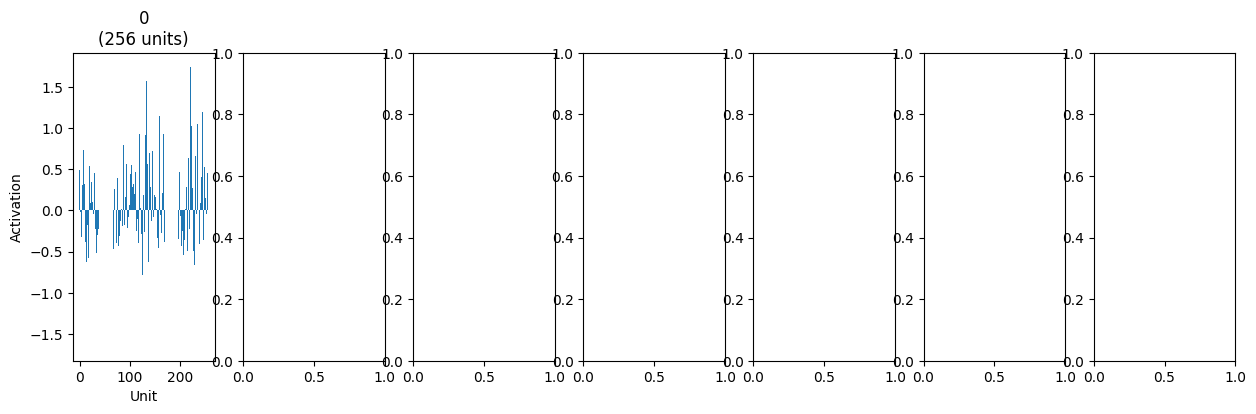

In [7]:
main()

print("\n" + "=" * 50)
print("HOOK-BASED ACTIVATION EXTRACTION SUMMARY")
print("=" * 50)
print("1. Create ActivationExtractor with your model")
print("2. Register hooks with register_hooks()")
print("3. Run get_activations(input) to extract")
print("4. Always call clear_hooks() when done")
print("\nKey benefits:")
print("- Works with any PyTorch model")
print("- No model modification needed")
print("- Can target specific layers")
print("- Memory efficient with detach()")